# Semantic mapping for KG visualization

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../semantic_mapping'))
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import circlify
import time as time

# Util library
import semantic_similarity

from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics


# Computing similarity matrix
dataset_name = 'star_wars'
#semantic_similarity.build_similarity_matrix(dataset_name)

# Load similarity matrix

sim_matrix = np.loadtxt("similarity_matrices/{0}.txt".format(dataset_name))
lst_names = semantic_similarity.load_names(dataset_name)

display(sim_matrix)
display(lst_names)


array([[1.        , 0.20658502, 0.45457231, 0.20330699, 0.32833648,
        0.22585213, 0.40082475, 0.22660715, 0.07593365, 0.23240819,
        0.21547751, 0.22332912, 0.45056649, 0.20910803, 0.17421916,
        0.57318112, 0.22913016],
       [0.20658502, 1.        , 0.50222651, 0.71403842, 0.26746095,
        0.44261771, 0.26050633, 0.2985747 , 0.08877456, 0.30628435,
        0.28461973, 0.7806553 , 0.62602864, 0.41593558, 0.21571276,
        0.29739824, 0.44704933],
       [0.45457231, 0.50222651, 1.        , 0.49590235, 0.35356859,
        0.53693028, 0.34043674, 0.34920482, 0.09552059, 0.3599606 ,
        0.50075187, 0.34288066, 0.72322875, 0.50665812, 0.24056213,
        0.74266076, 0.54325444],
       [0.20330699, 0.71403842, 0.49590235, 1.        , 0.40379432,
        0.43629355, 0.25607472, 0.29225054, 0.08786547, 0.48790086,
        0.27829557, 0.58592176, 0.4312951 , 0.55226895, 0.21243473,
        0.29107408, 0.57516599],
       [0.32833648, 0.26746095, 0.35356859, 0.403794

['John_Sheppard_(Stargate)',
 'Boba_Fett',
 'Wedge_Antilles',
 'Asajj_Ventress',
 'RoboCop_(character)',
 'Princess_Leia',
 'Jacen_Solo',
 'Kreia',
 'Dan_Dare',
 'General_Grievous',
 'Chewbacca',
 'Jango_Fett',
 'Han_Solo',
 'Darth_Vader',
 'Palpatine',
 'Lando_Calrissian',
 'Luke_Skywalker']

In [2]:
# Compute clusters using Affinity Propagation algorithm
print("Compute affinity propagation clustering...")
clustering = AffinityPropagation(random_state=10, max_iter=800).fit(sim_matrix)
display(clustering.labels_)
display(clustering.cluster_centers_indices_)

# Compute Intrinsic Measures to evaluate the cluster quality for Affinity Propagation
print("Silhouette index: %0.3f" % metrics.silhouette_score(sim_matrix, clustering.labels_, metric="sqeuclidean"))
print("Davies Bouldin score: %0.3f" % davies_bouldin_score(sim_matrix, clustering.labels_))
print("Calinski Harabasz score: %0.3f" % metrics.calinski_harabasz_score(sim_matrix, clustering.labels_))

array([3, 0, 3, 0, 4, 4, 2, 2, 1, 4, 2, 0, 3, 4, 2, 3, 4])

array([ 1,  8, 10, 15, 16])

Silhouette index: 0.367
Davies Bouldin score: 1.074
Calinski Harabasz score: 5.293


In [3]:
# Compute hierarchical-algorithm

print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=5, linkage="single").fit(sim_matrix)
elapsed_time = time.time() - st

print("Silhouette index: %0.3f" % metrics.silhouette_score(sim_matrix, ward.labels_, metric="sqeuclidean"))
print("Davies Bouldin score: %0.3f" % davies_bouldin_score(sim_matrix, ward.labels_))
print("Calinski Harabasz score: %0.3f" % metrics.calinski_harabasz_score(sim_matrix, ward.labels_))

Compute unstructured hierarchical clustering...
Silhouette index: 0.217
Davies Bouldin score: 1.096
Calinski Harabasz score: 3.515


In [13]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(sim_matrix, quantile=0.77, n_samples=289)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
ms.fit(sim_matrix)

print("Silhouette index: %0.3f" % metrics.silhouette_score(sim_matrix, ms.labels_, metric="sqeuclidean"))
print("Davies Bouldin score: %0.3f" % davies_bouldin_score(sim_matrix, ms.labels_))
print("Calinski Harabasz score: %0.3f" % metrics.calinski_harabasz_score(sim_matrix, ms.labels_))

Silhouette index: 0.571
Davies Bouldin score: 0.457
Calinski Harabasz score: 4.153


In [4]:
# Create semantic maps using the exemplars as centers
exemplars_label_dict = {}
for i in range(0, len(clustering.labels_)):
    if clustering.labels_[i] not in exemplars_label_dict.keys():
        exemplars_label_dict[clustering.labels_[i]] = []
    exemplars_label_dict[clustering.labels_[i]].append(i)

# Replace the key in the dict to use the exmplar index as key instead of cluster label
exemplars_dict = {}
for k, v in exemplars_label_dict.items():
    filtered = filter(lambda center: center in clustering.cluster_centers_indices_, v)
    exemplars_dict[list(filtered)[0]] = v
del exemplars_label_dict


# Create list of edges
lst_sources = []
lst_targets = []
for k, v in exemplars_dict.items():
    for idx in v:
        if idx != k or len(v) == 1:
            lst_sources.append(lst_names[k])
            lst_targets.append(lst_names[idx])

# Create DataFrame
df = pd.DataFrame(list(zip(lst_sources, lst_targets)), columns=['source', 'target'])
display(df)


,source,target
0,Lando_Calrissian,John_Sheppard_(Stargate)
1,Lando_Calrissian,Wedge_Antilles
2,Lando_Calrissian,Han_Solo
3,Boba_Fett,Asajj_Ventress
4,Boba_Fett,Jango_Fett
5,Luke_Skywalker,RoboCop_(character)
6,Luke_Skywalker,Princess_Leia
7,Luke_Skywalker,General_Grievous
8,Luke_Skywalker,Darth_Vader
9,Chewbacca,Jacen_Solo


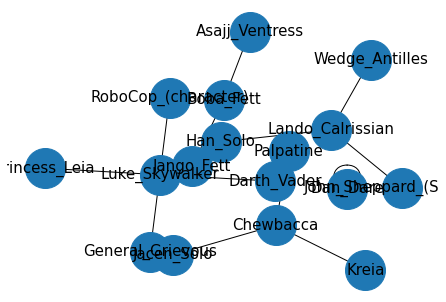

In [5]:
# Draw static network
G = nx.from_pandas_edgelist(df,
                           source='source',
                           target='target')
nx.draw_kamada_kawai(G,
                    with_labels=True,
                    node_size=1600,
                     edge_color='black',
                     linewidths=1,
                     font_size=15)

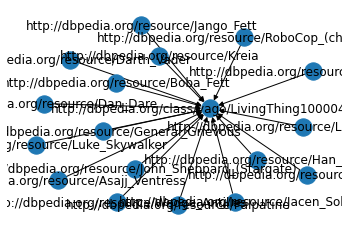

In [6]:
from pyvis.network import Network
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

g = rdflib.Graph()
result = g.parse("datasets/{0}.nt".format(dataset_name))
GG = rdflib_to_networkx_multidigraph(result)

pos = nx.spring_layout(GG, scale=2)
edge_labels = nx.get_edge_attributes(GG, 'r')
nx.draw_networkx_edge_labels(GG, pos, edge_labels=edge_labels)
nx.draw(GG, with_labels=True)

#if not in interactive mode for 
plt.show()

net = Network(notebook=True)
net.from_nx(G)
net.show('demo.html')